# Check and See Data

### Convert netCDF4 to hdf5 files

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras

from tqdm import tqdm
from math import ceil
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator
from preprocess import ProdKernel, FKernel, Preprocess, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  CST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


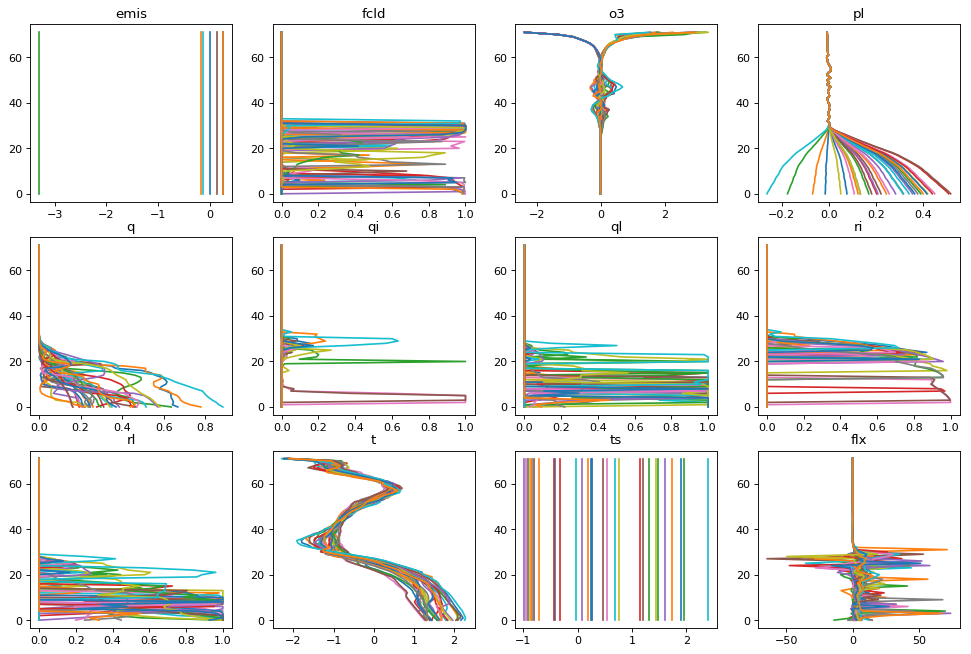

In [2]:
D2 = DictPrepross(['o3','pl'], [Level_Normalizer(False),Level_Normalizer(True)] )
D = Load_FLX_dict()
B = Diff_Generator(data_folder, batch_size=32, preprocess_x=[D,D2])
header = B.variables
x0,y0 = B[0]
x0 = x0.swapaxes(1,2)
Plot_Batch(x0,y0, B.variables)

In [13]:
test_500_gen =  Up_and_Down_Generator(shuffle=False, train=False, preprocess_x=[D])
train_400_gen =  Up_and_Down_Generator(shuffle=False, train=True, preprocess_x=[D])

In [14]:
#test_500_gen.current_folder
print(len(train_400_gen)/4*3)
train_400_gen.List_of_dir

29160.0


['Data/20190331_2200z',
 'Data/20190401_0000z',
 'Data/20190401_0200z',
 'Data/20190401_0400z']

In [22]:
x0,y0 = train_400_gen[29160+500];
x1,y1 = test_500_gen[500];
#print(train_400_gen.current_folder, train_400_gen.current_file, train_400_gen.current_b)

In [16]:
#Plot_Batch(x0.swapaxes(1,2), y0, train_400_gen.variables )

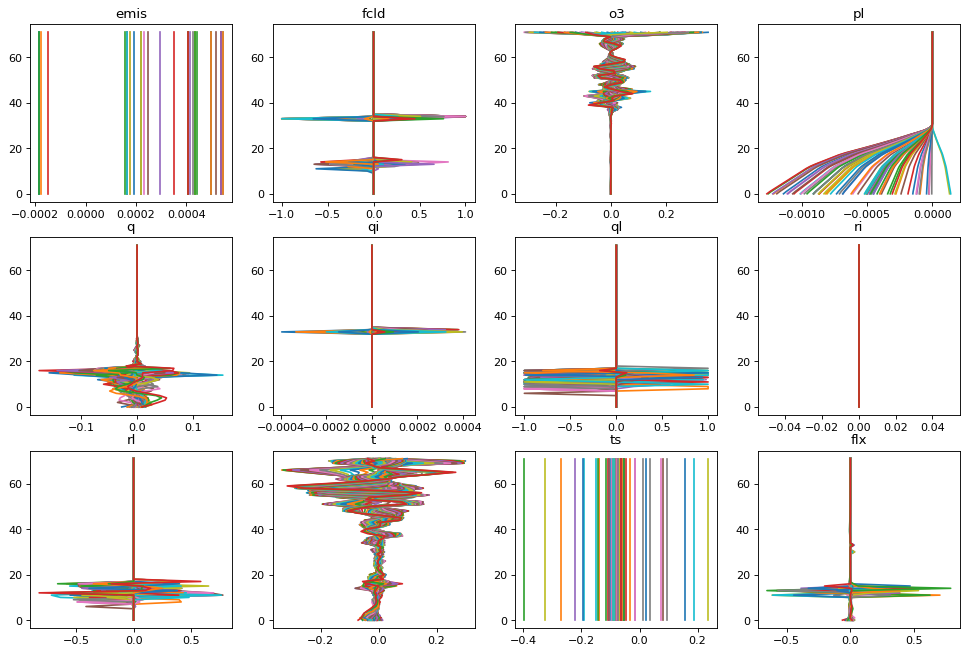

In [23]:
Plot_Batch( (x1-x0).swapaxes(1,2), (y1-y0)[:,:,[2]], train_400_gen.variables )

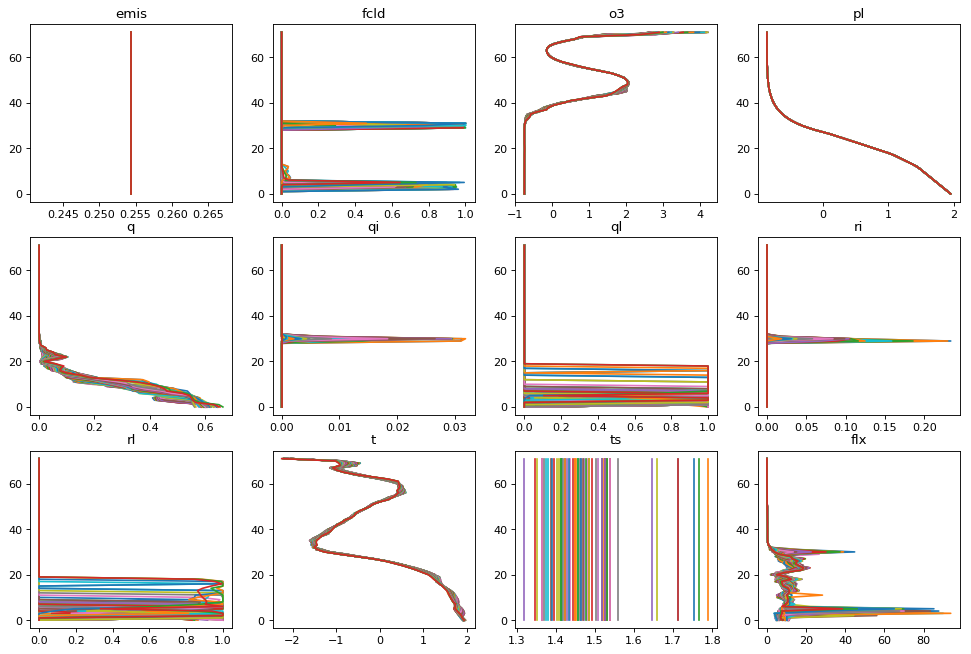

In [18]:
Plot_Batch(x0.swapaxes(1,2), y0[:,:,[0]], train_400_gen.variables )

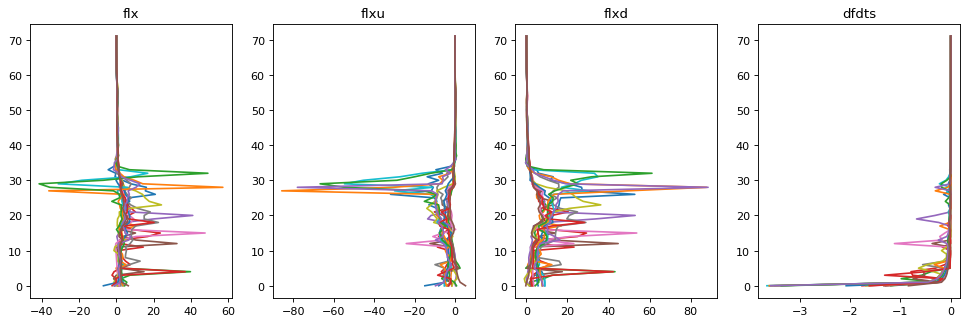

In [4]:
from generator import Full_Diff_Generator

FD = Full_Diff_Generator(chosen_var=['flx','flxu','flxd','dfdts'], batch_size=16)

def Plot_4_Profiles(y, B_vars):
    f=plt.figure( figsize=(15,10), dpi=80)
    for i in range(len(B_vars)):
        ax= f.add_subplot(2, 4, i+1)
        ax.set_title(B_vars[i])
        for b in range(y.shape[0]):
            ax.plot(np.flip(y[b,i,:]), np.arange(len(y[b,i,:])))
            #ax.plot( np.flip(np.cumsum(y,axis=1).T[:,j]) , np.arange(len(y[b,i,:]) )
            
x,y = FD[0]
Plot_4_Profiles(y, B_vars=FD.new_variables_pred)

#### Different delta t for each zone

In [6]:
from net_to_panda import Convert_all_from

Convert_all_from(data_folder,data_folder)

Creating out_folder Data/20190401_0400z
0
1
2
3
4
---------
Creating out_folder Data/20190401_0400z/20190401_0400z
0
1
2
3
4
---------


Text(0.5, 1.0, 'dfdts')

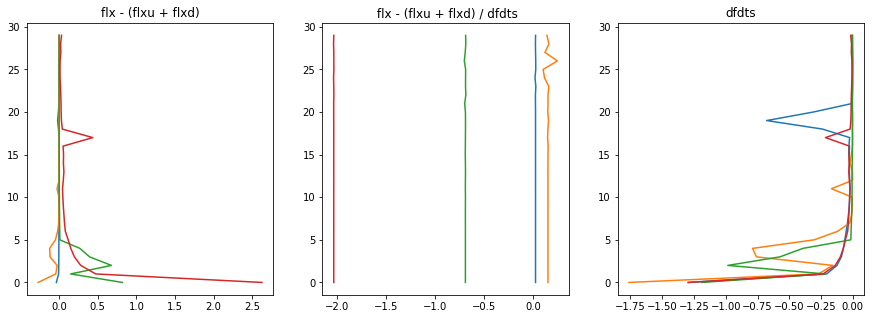

In [59]:
i=[1,2,3,4]
f = plt.figure(figsize=(15,5))
ax=plt.subplot(131)
plt.plot( np.flip(  (y[i,0,:] -  y[i,1,:] -  y[i,2,:])).T[:30], np.arange(30) );
plt.title('flx - (flxu + flxd)')
ax=plt.subplot(132)
plt.plot( np.flip(  (y[i,0,:] -  y[i,1,:] -  y[i,2,:])/((y[i,3,:]) +0.0000001  )).T[:30],np.arange(30) );
plt.title(' flx - (flxu + flxd) / dfdts')
ax=plt.subplot(133)
plt.plot( np.flip( (y[i,3,:])).T[:30] ,np.arange(30) );
plt.title('dfdts');

In [50]:
c=(y[i,0,:] -  y[i,1,:] -  y[i,2,:])/((y[i,3,:]) +0.0000001)
c[:,-1]

array([-2.0317962 , -0.688932  ,  0.15325896], dtype=float32)

In [7]:
## GET DICTIONNARY :
header_dict = ['rl', 'ri', 'ql', 'qi', 'q', 'ts', 't', 'emis', 'o3', 'pl']
fct = [] # how to preprocess them
for i in range(5):
    fct.append(Zero_One())
for j in range(5):
    fct.append(Normalizer())

if os.path.isfile('DictPreprocess_fit.hdf5'):
    Dhd = pd.read_hdf('DictPreprocess_fit.hdf5', key='s')
    D = DictPrepross(header_dict, fct)
    D.load_from_pd(Dhd)
else:
    print("Fitting Dict")
    B = Basic_Generator(data_folder)   
    xdim, ydim = B.Xdim, B.Ydim
    B = Basic_Generator(data_folder, batch_size=xdim*ydim, shuffle=False, )
    D = DictPrepross(header_dict, fct)
    D.fitonGen(B)
    Dhd = D.to_array_save()
    Dhd.to_hdf('DictPreprocess_fit.hdf5', key='s')

 ple(:,:,0) = 1
 do k=1,lm
   ple(:,:,k) = 2*pl(:,:,k) - ple(:,:,k-1)
   dp(:,:,k) = ple(:,:,k)-ple(:,:,k-1)
 enddo

 !Temperature at levels
 allocate(tlev(im,jm,lm+1))

 do k = 2, lm
    tlev(:,:,k)=  ( t(:,:,k-1)*dp(:,:,k) + t(:,:,k)*dp(:,:,k-1) ) / (dp(:,:,k-1) + dp(:,:,k))
 enddo
 
 tlev(:,:,lm+1) = t(:,:,lm)*(0.5*(1.0 + ple(:,:,lm-1)/ple(:,:,lm)))**(-mapl_kappa) !t2m adiabatic
 tlev(:,:,   1) = tlev(:,:,2)

### PLOTTING SOME DATAS

466 3619


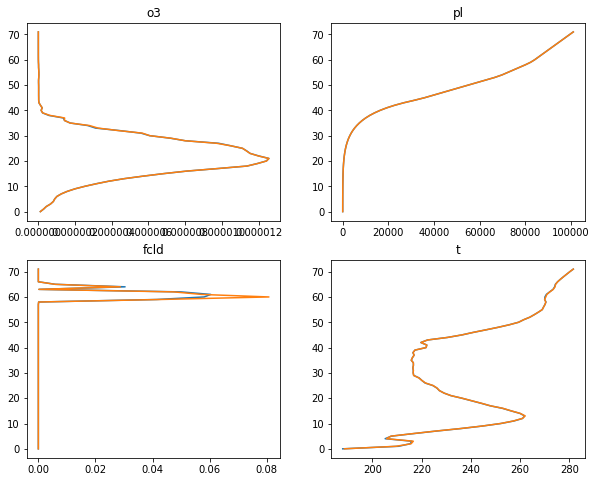

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure

idx = int(np.random.random()*n)
idy = int(np.random.random()*p)
print(idx, idy)

fig = plt.figure( figsize=(10, 8))
ax1 = fig.add_subplot(221)
plt.plot(x["o3"][0,:,idy,idx], np.arange(72)); plt.title("o3")
plt.plot(x["o3"][0,:,idy-1,idx], np.arange(72)); plt.title("o3")
ax2 = fig.add_subplot(222)
plt.plot(x["pl"][0,:,idy,idx], np.arange(72)); plt.title("pl")
plt.plot(x["pl"][0,:,idy-1,idx], np.arange(72)); plt.title("pl")
ax3 = fig.add_subplot(223)
plt.plot(x["fcld"][0,:,idy,idx], np.arange(72)); plt.title("fcld")
plt.plot(x["fcld"][0,:,idy-1,idx], np.arange(72)); plt.title("fcld")
ax4 = fig.add_subplot(224)
plt.plot(x["t"][0,:,idy,idx], np.arange(72)); plt.title("t")
plt.plot(x["t"][0,:,idy-1,idx], np.arange(72)); plt.title("t")

plt.show()

43 2525


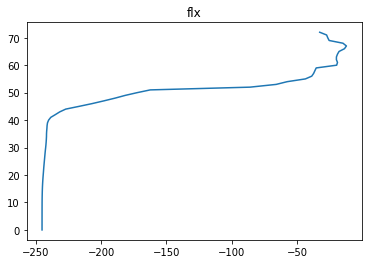

In [20]:
print(idx,idy)
#plt.plot(np.flip(y["flx"][0, 0:-1 ,idy,idx])-np.flip(y["flx"][0,1:,idy,idx]), np.arange(72)); plt.title("flx");
plt.plot(y["flx"][0,:,idy-1,idx], np.arange(73)); plt.title("flx");

In [23]:
np.max(y['flx'][:,-1])

55.072926

In [18]:
y["flx"][0,0,idy,idx]
y["flx"][0,1,idy,idx]

masked_array(data=-243.10362,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

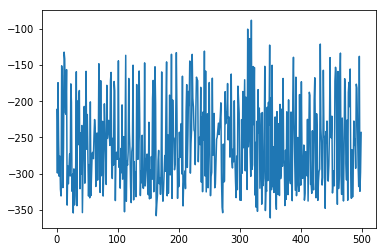

In [12]:
dif=[]

for i in range(500):
    idx = int(np.random.random()*n)
    idy = int(np.random.random()*p)
    dif.append(np.flip(y["flx"][0,0,idy,idx]))# - np.flip(y["flx"][0,1,idy,idx]))
plt.plot(dif);

In [13]:
np.min(y['flx'])

-385.70572

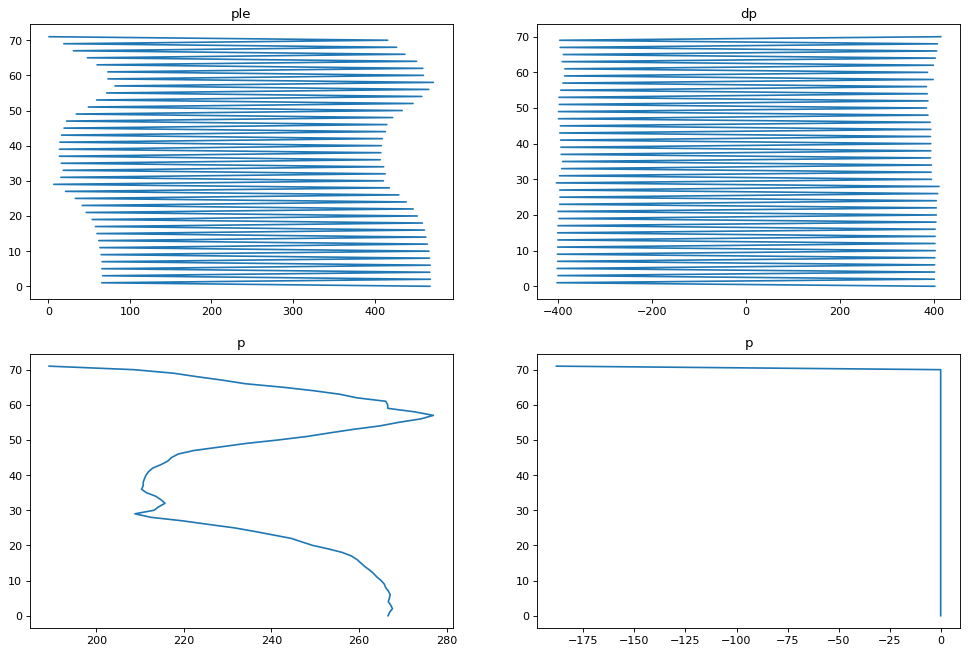

In [221]:
import matplotlib.pyplot as plt
def Plot(ax1, l, title=''):
    alt = np.arange(len(l))
    ax1.plot(np.flip(l),alt)
    ax1.set_title(title)
    
def fct_ple(p):
    b, lev = p.shape
    ple = np.zeros((b,lev))
    dp = np.zeros((b,lev))
    ple[:,0]=1
    for k in range(1,lev):
        ple[:,k] = 2*p[:,k] - ple[:,k-1]
        dp[:,k] = ple[:,k]-ple[:,k-1]
    return(ple, dp)

p = np.array(B.X.t)
ple,dp = fct_ple(p)

i=99
f=plt.figure( figsize=(15,10), dpi=80)
ax1 = f.add_subplot(221)
Plot(ax1, ple[i], 'ple')
ax2 = f.add_subplot(222)
Plot(ax2, dp[i][1:],'dp')
ax3 = f.add_subplot(223)
Plot(ax3, p[i],'p')
ax3 = f.add_subplot(224)
Plot(ax3, ple[i]-p[i]-1/2*dp[i],'p')

0.9907 0.9907
295.0831 295.0831


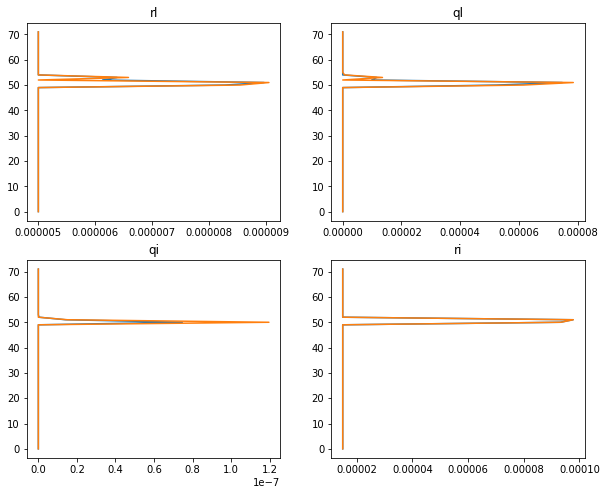

In [98]:
fig = plt.figure( figsize=(10, 8))
ax1 = fig.add_subplot(221)
plt.plot(x["rl"][0,:,idy,idx], np.arange(72)); plt.title("rl")
plt.plot(x["rl"][0,:,idy-1,idx], np.arange(72)); plt.title("rl")
ax2 = fig.add_subplot(222)
plt.plot(x["ql"][0,:,idy,idx], np.arange(72)); plt.title("ql")
plt.plot(x["ql"][0,:,idy-1,idx], np.arange(72)); plt.title("ql")
ax3 = fig.add_subplot(223)
plt.plot(x["qi"][0,:,idy,idx], np.arange(72)); plt.title("qi")
plt.plot(x["qi"][0,:,idy-1,idx], np.arange(72)); plt.title("qi")
ax4 = fig.add_subplot(224)
plt.plot(x["ri"][0,:,idy,idx], np.arange(72)); plt.title("ri")
plt.plot(x["ri"][0,:,idy-1,idx], np.arange(72)); plt.title("ri")
print(x["emis"][0,idy-1,idx], x["emis"][0,idy-1,idx])
print(x["ts"][0,idy-1,idx], x["ts"][0,idy-1,idx])

In [35]:
def PlotVar(v,x,idx,idy):
    plt.plot( np.flip(x[v][0,:,idy,idx]), np.arange(len(x[v][0,:,idy,idx])))
    plt.title(v)

174 154


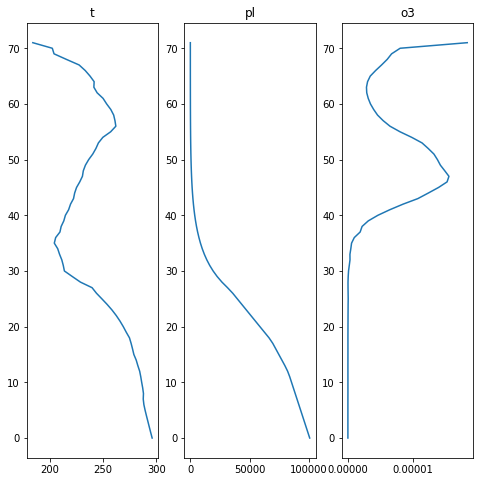

In [36]:
idx = int(np.random.random()*n)
idy = int(np.random.random()*p)
print(idx, idy)
fig = plt.figure( figsize=(8, 8))
ax1 = fig.add_subplot(131)
PlotVar('t', x, idx, idy)
ax2 = fig.add_subplot(132)
PlotVar('pl', x, idx, idy)
ax3 = fig.add_subplot(133)
PlotVar('o3', x, idx, idy)

In [123]:
pd.DataFrame(data=data[1:,1:],    # values
              index=data[1:,0],    # 1st column as index
              columns=data[0,1:])  # 1st row as the column names

86.98259

In [222]:
x['t']

<class 'netCDF4._netCDF4.Variable'>
float32 t(time, lev, Ydim, Xdim)
    long_name: air_temperature
    units: K
    _FillValue: 1000000000000000.0
    missing_value: 1000000000000000.0
    fmissing_value: 1000000000000000.0
    scale_factor: 1.0
    add_offset: 0.0
    standard_name: air_temperature
    vmin: -1000000000000000.0
    vmax: 1000000000000000.0
    valid_range: [-1.e+15  1.e+15]
    coordinates: lons lats
unlimited dimensions: time
current shape = (1, 72, 4320, 720)
filling on

### RL, RI analysis :

* They have a hard minimum, we should set it to 0
* They should be rescaled

In [123]:
print(np.min(x["ri"][:]),np.max(x["ri"][:]))
print(np.min(x["rl"][:]),np.max(x["rl"][:]))

1.5e-05 0.00010348039
5e-06 2.1e-05


428 1483


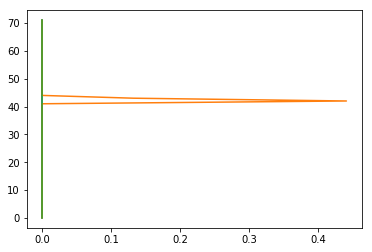

In [262]:
# RL, RI analysis

idx = int(np.random.random()*n)
idy = int(np.random.random()*p)
print(idx,idy)
plt.plot(((x["ri"][0,:,idy,idx]-1.5e-05)/0.0001).T,np.arange(72))
plt.plot((x["fcld"][0,:,idy,idx]).T,np.arange(72))
plt.plot(((x["rl"][0,:,idy,idx]-5e-06)/2.1e-5).T,np.arange(72));

Data Prepross :
   * rl - min(rl) (i.e 1.5e-05)
   * ri - min(ri) (i.e 1.5e-06)

===================

700 1888


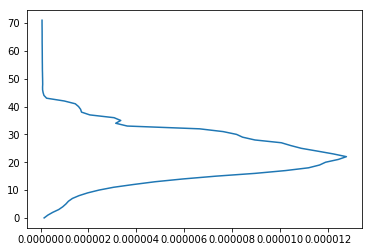

In [184]:
idx = int(np.random.random()*n)
idy = int(np.random.random()*p)
print(idx,idy)
plt.plot((x["o3"][0,:,idy,idx]).T,np.arange(72))
#plt.plot((x["pl"][0,:,idy,idx]).T,np.arange(72));

51 1674


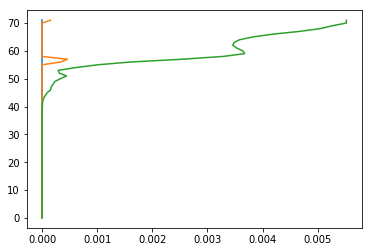

In [321]:
idx = int(np.random.random()*n)
idy = int(np.random.random()*p)
print(idx,idy)

#a=y['flx'][:].mean()
#b=y['flx'][:].std()

plt.plot(x["qi"][0,:,idy,idx].T,np.arange(72));
plt.plot(x["ql"][0,:,idy,idx].T,np.arange(72));
plt.plot(x["q"][0,:,idy,idx].T,np.arange(72));

In [7]:
d=dict()
d0 = y['flx'][:].std()
for k in x.keys():
    d[k] = x[k][:].std()

In [2]:
cov = []
v1=y['flx'][:].flatten()[-10000:]
for i,k in enumerate(x.keys()):
    if(len(x[k].shape)>3):
        print(k)
        v2=x[k][:].flatten()[-10000:]
        cov.append(np.corrcoef(v1,v2)[0,1])

fcld
o3
pl
q
qi


/home/victor/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/victor/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


ql
ri
rl
t


In [6]:
v2=x['qi'][:].flatten()[-10000:]
print(np.max(v2), np.min(v2))

0.0 0.0


In [41]:
f=plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

def plotvar(x, var, id=0):
    if(len(x[var].shape)<4):
        t = x[var][0].T 
    else:
        t = x[var][0,id].T 
    y0 = np.arange(n)
    x0 = np.arange(p)

    nrows, ncols = n, p
    grid = t#temp.reshape((nrows, ncols))

    plt.imshow(grid, extent=(x0.min(), x0.max(), y0.max(), y0.min()),
               interpolation='nearest', cmap=cm.gist_rainbow)

<Figure size 640x480 with 0 Axes>

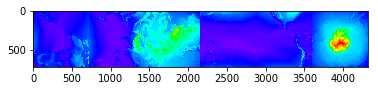

In [42]:
plotvar(x, 'ts');

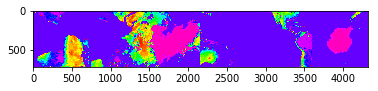

In [39]:
plotvar(x, 'emis');

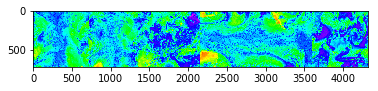

In [44]:
plotvar(y, 'flx', -1);

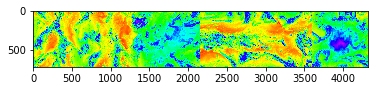

In [45]:
plotvar(y, 'flx', 0);

In [316]:
for k in x.keys():
    print( "{} : {}".format(k ,x[k].long_name))

Xdim : Fake Longitude for GrADS Compatibility
Ydim : Fake Latitude for GrADS Compatibility
lons : longitude
lats : latitude
lev : vertical level
time : time
emis : surface_emissivity
fcld : cloud_fraction_for_radiation
o3 : ozone_mass_mixing_ratio
pl : mid_level_pressure
q : specific_humidity
qi : in_cloud_cloud_ice_for_radiation
ql : in_cloud_cloud_liquid_for_radiation
ri : ice_phase_cloud_particle_effective_radius
rl : liquid_cloud_particle_effective_radius
t : air_temperature
ts : surface_skin_temperature


# OUTPUTS

In [102]:
def Plot(L):
    fig = plt.figure( figsize=(10, 8))
    alt = np.arange(73)
    ax1 = fig.add_subplot(221)
    plt.plot(L[0,0],alt)
    plt.plot(L[1,0],alt)
    plt.title("flxu")

    ax2 = fig.add_subplot(222)
    plt.plot(L[0,1],alt)
    plt.plot(L[1,1],alt)
    plt.title("flxd")

    ax3 = fig.add_subplot(223)
    plt.plot(L[0,2],alt)
    plt.plot(L[1,2],alt)
    plt.title("dfdts")

    ax4 = fig.add_subplot(224)
    plt.plot(L[0,0]+L[0,1],alt)
    plt.plot(L[1,0]+L[1,1],alt)
    plt.title("flx");

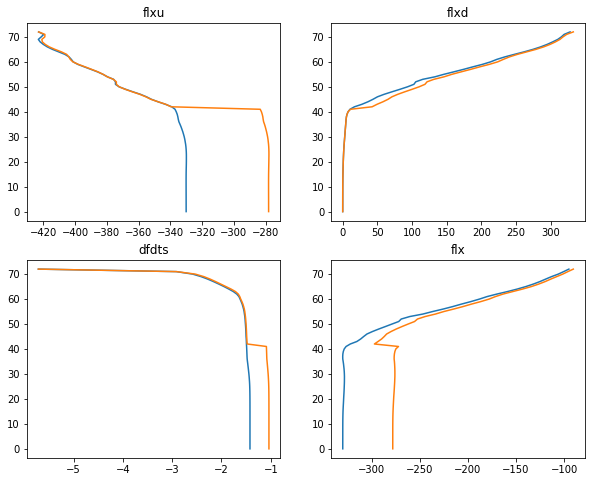

In [107]:
import numpy as np
import matplotlib.pyplot as plt


def Plot(L):
    fig = plt.figure( figsize=(10, 8))
    alt = np.arange(73)
    ax1 = fig.add_subplot(221)
    plt.plot(L[0,0],alt)
    plt.plot(L[1,0],alt)
    plt.title("flxu")

    ax2 = fig.add_subplot(222)
    plt.plot(L[0,1],alt)
    plt.plot(L[1,1],alt)
    plt.title("flxd")

    ax3 = fig.add_subplot(223)
    plt.plot(L[0,2],alt)
    plt.plot(L[1,2],alt)
    plt.title("dfdts")

    ax4 = fig.add_subplot(224)
    plt.plot(L[0,0]+L[0,1],alt)
    plt.plot(L[1,0]+L[1,1],alt)
    plt.title("flx");

#########################
file1 = 'output.txt'
plotfile = 'q.png'
id_profile = 0
#######################

id=-1
Profiles = []
profile = np.zeros((2,3,73))
j0=0
for i,line in enumerate(open(file1)):
    l = line.rstrip('\n').strip(' ')
    l = l.split(' ')
    if(l[0]=='Profile'):
        j0=-3
        Profiles.append(profile.copy())
        profile = np.zeros((2,3,73))
        id=-1
        
    if(j0>=0):
        if(len(l)==1):
            id+=1
            j=0
        else:
            if(l[0][0]=='-'):
                profile[0,id,j] = -float(l[0][1:])
            else:
                profile[0,id,j] = float(l[0])
            if(l[-1][0]=='-'):
                profile[1,id,j] = -float(l[-1][1:])
            else:
                profile[1,id,j] = float(l[-1])
            j+=1
    j0+=1

Profiles.append(profile)
Profiles = Profiles[1:]

Plot(Profiles[id_profile])
plt.savefig(plotfile, bbox_inches='tight')

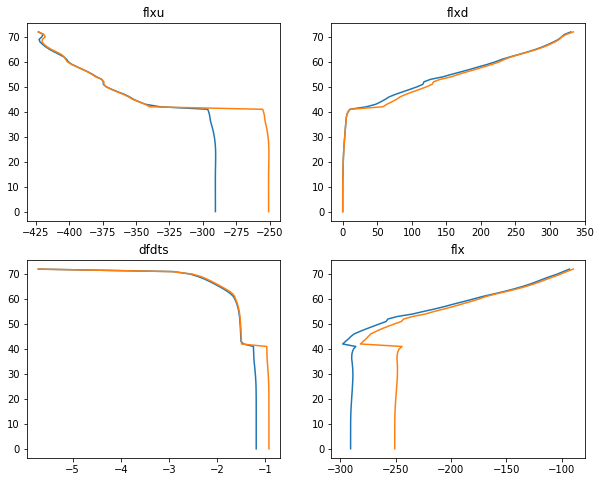

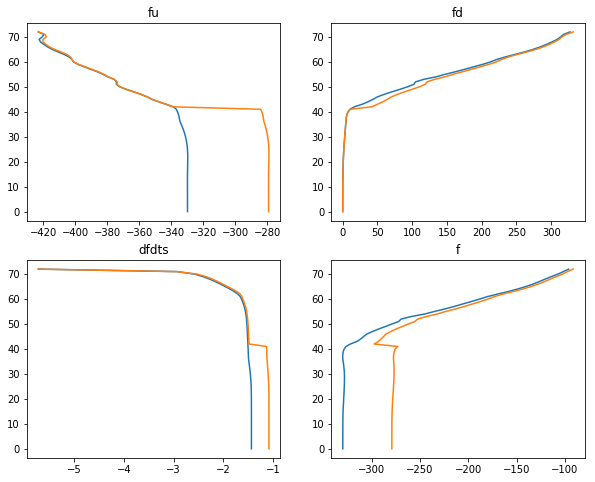

In [100]:
Plot(Profiles[3])